# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import IndexLocator
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
import numpy as np

In [ ]:
df = pd.read_csv("./drive/MyDrive/TimeSeries/daily-minimum-temperatures-in-me.csv")

# Analisis inicial

In [ ]:
df.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        3650 non-null   object 
 1   Daily minimum temperatures  3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [ ]:
df.rename(columns={"Daily minimum temperatures": "Temperature"}, inplace=True)

In [ ]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


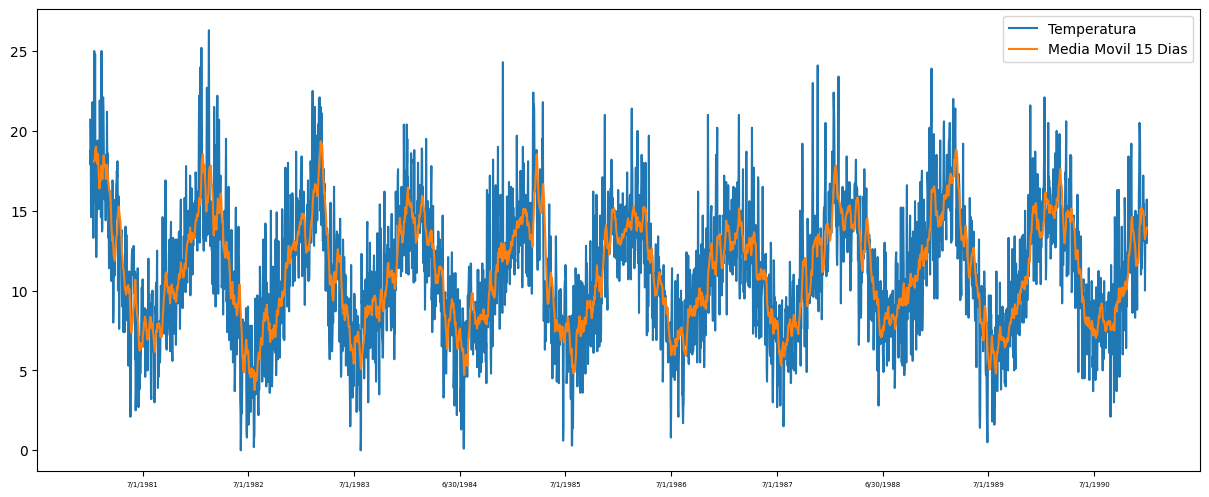

In [ ]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df["Date"],df["Temperature"],label="Temperatura")
df['media_movil_15d'] = df['Temperature'].rolling(window=15).mean()
ax.plot(df["Date"],df["media_movil_15d"],label="Media Movil 15 Dias")

locator = IndexLocator(base=365, offset=181)
ax.xaxis.set_major_locator(locator)

plt.legend()
plt.show()

In [ ]:
len(df["Temperature"])/7

521.4285714285714

In [ ]:
df = df.drop("media_movil_15d", axis=1)

In [ ]:
# Convert the date column to a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample the daily data into weekly intervals and calculate the mean temperature
weekly_temps = df.resample('7D').mean()

# Print the resulting weekly temperature data
print(weekly_temps.head())

            Temperature
Date                   
1981-01-01    17.057143
1981-01-08    18.128571
1981-01-15    20.357143
1981-01-22    16.328571
1981-01-29    17.414286


In [ ]:
weekly_temps.describe()

,Temperature
count,522.000000
mean,11.181432
std,3.402325
min,2.542857
25%,8.546429
50%,11.050000
75%,13.614286
max,20.357143


In [ ]:
# Definir la función seno/coseno con periodo 52, centrado en 11 y con máximos de 18 y mínimos de -8
def sinusoid(x):
    return 11 + 8 * np.sin(2 * np.pi / 52 * (x - 11) + np.pi)

# Crear un array de valores de x
x = np.linspace(0, 522, 522)

# Calcular los valores de y para cada valor de x
y = sinusoid(x)

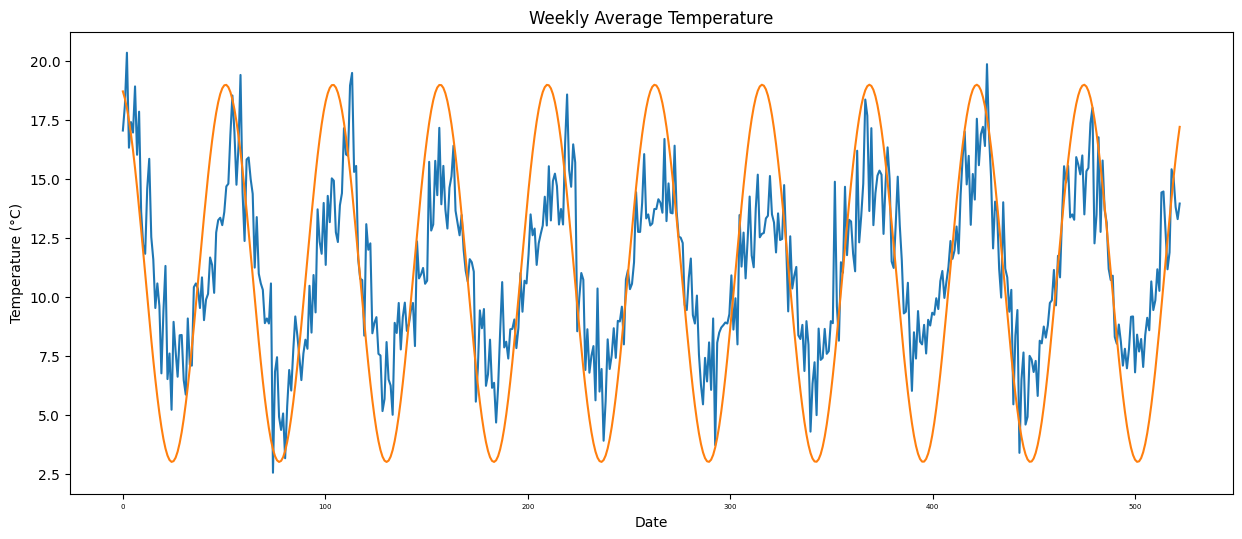

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.plot(x,weekly_temps["Temperature"])
plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Weekly Average Temperature')
plt.show()

In [ ]:
dif = [0] * len(weekly_temps['Temperature'])

for i in range(len(weekly_temps['Temperature'])-1):
  dif[i+1] = weekly_temps['Temperature'][i+1] - weekly_temps['Temperature'][i]

In [ ]:
weekly_temps['Dif_temp']=dif

In [ ]:
dif_2 = [0] * len(weekly_temps['Dif_temp'])

for i in range(len(weekly_temps['Dif_temp'])-53):
  dif_2[i+52] = weekly_temps['Dif_temp'][i+53] - weekly_temps['Dif_temp'][i]

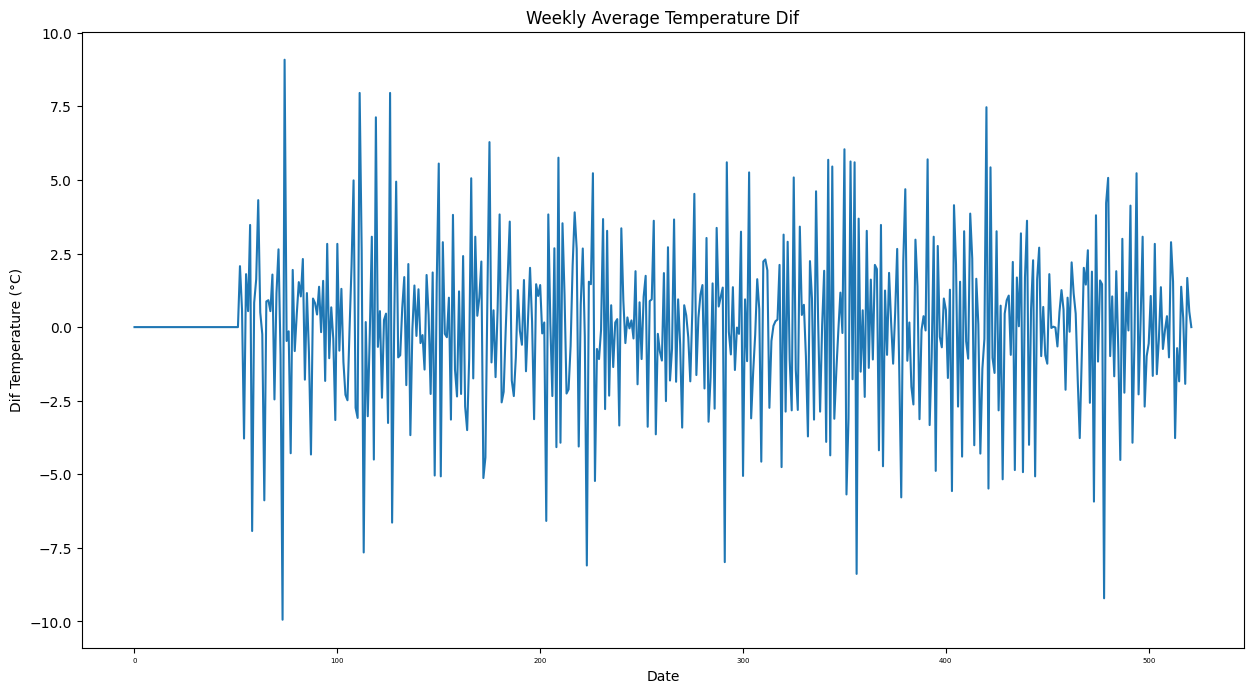

In [ ]:
plt.plot(dif_2)
plt.xlabel('Date')
plt.ylabel('Dif Temperature (°C)')
plt.title('Weekly Average Temperature Dif')
plt.show()

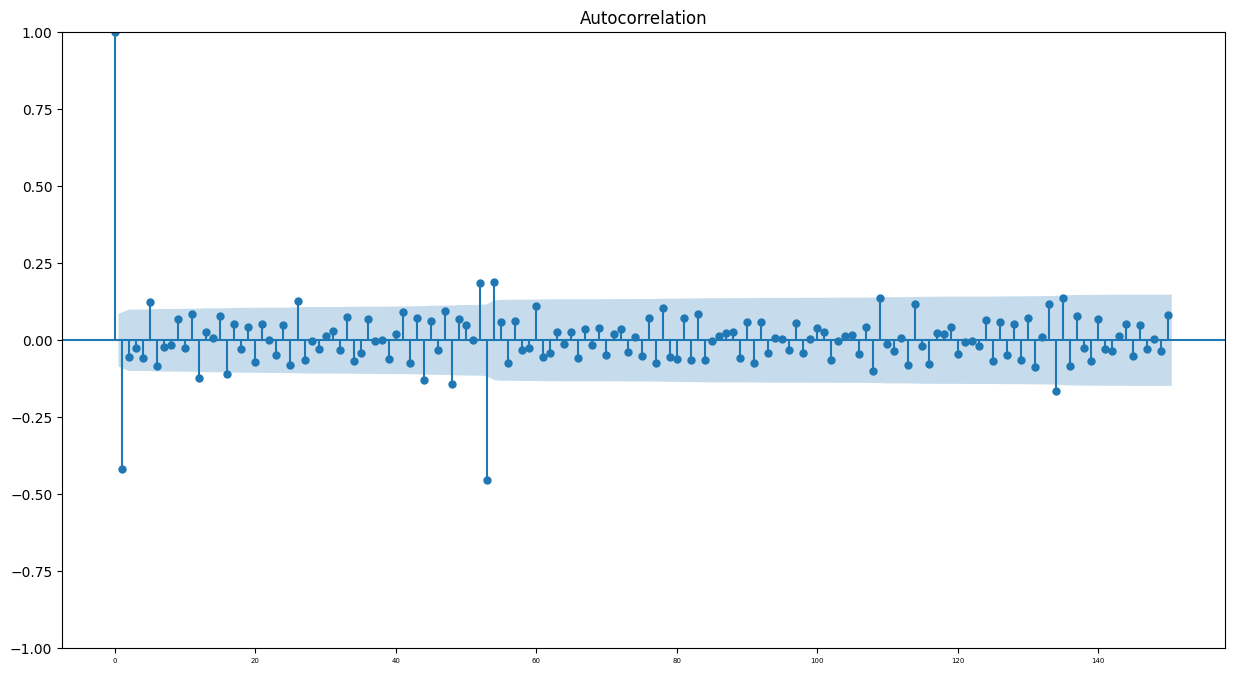

In [ ]:
plot_acf(dif_2, lags=150)
plt.show()
acf_vals = acf(dif_2, nlags=150)

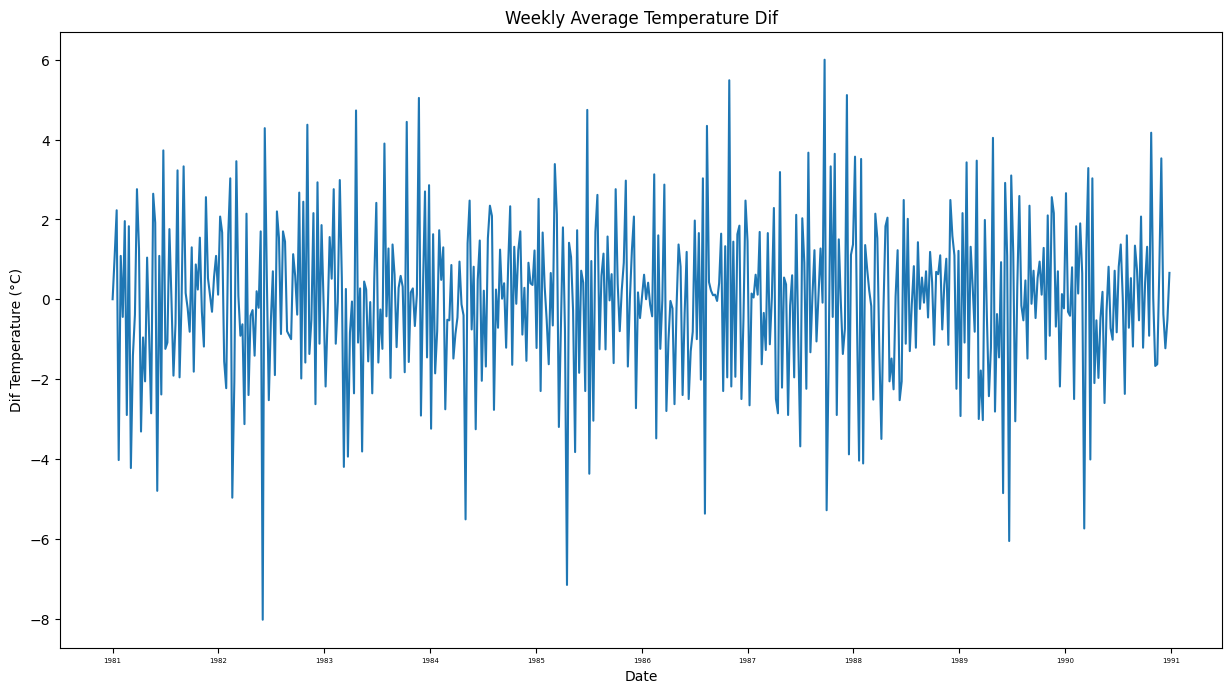

In [ ]:
plt.plot(weekly_temps['Dif_temp'])
plt.xlabel('Date')
plt.ylabel('Dif Temperature (°C)')
plt.title('Weekly Average Temperature Dif')
plt.show()

(array([ 1.,  3.,  2.,  5.,  8., 10., 14., 19., 30., 34., 41., 35., 16.,
        34., 31., 24., 23., 34., 39., 18., 23., 24., 17., 10., 12.,  4.,
         4.,  3.,  2.,  2.]),
 array([ 2.54285714,  3.13666667,  3.73047619,  4.32428571,  4.91809524,
         5.51190476,  6.10571429,  6.69952381,  7.29333333,  7.88714286,
         8.48095238,  9.0747619 ,  9.66857143, 10.26238095, 10.85619048,
        11.45      , 12.04380952, 12.63761905, 13.23142857, 13.8252381 ,
        14.41904762, 15.01285714, 15.60666667, 16.20047619, 16.79428571,
        17.38809524, 17.98190476, 18.57571429, 19.16952381, 19.76333333,
        20.35714286]),
 <BarContainer object of 30 artists>)

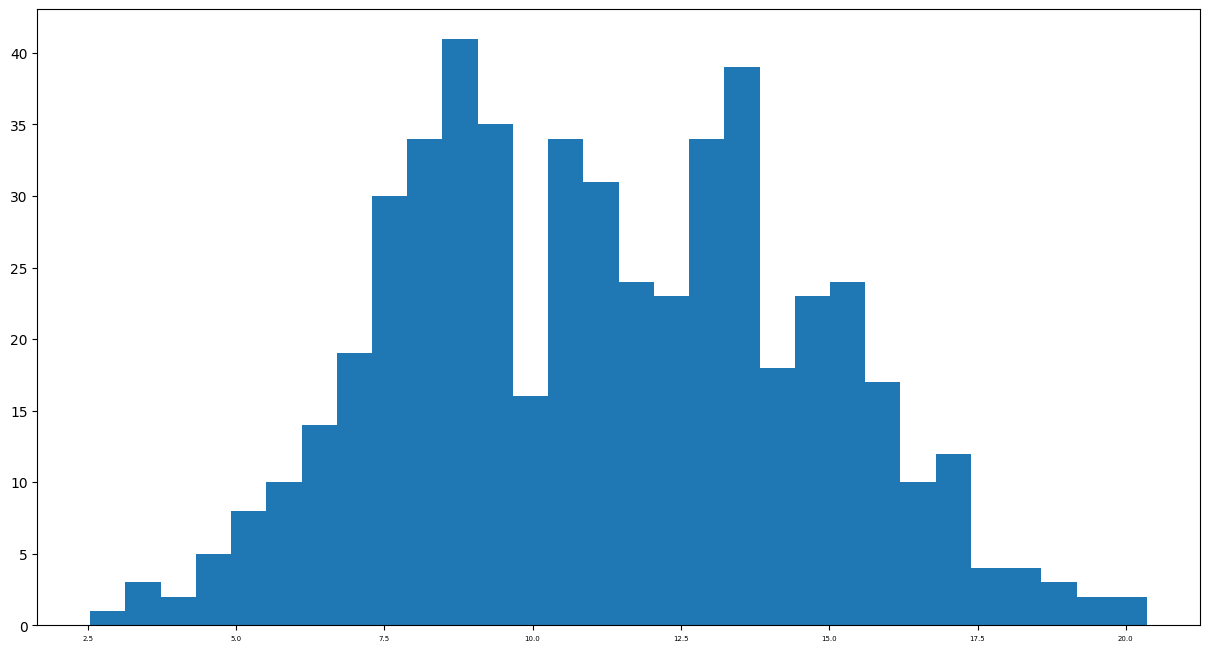

In [ ]:
_,ax1=plt.subplots()
ax1.hist(weekly_temps["Temperature"],bins=30)

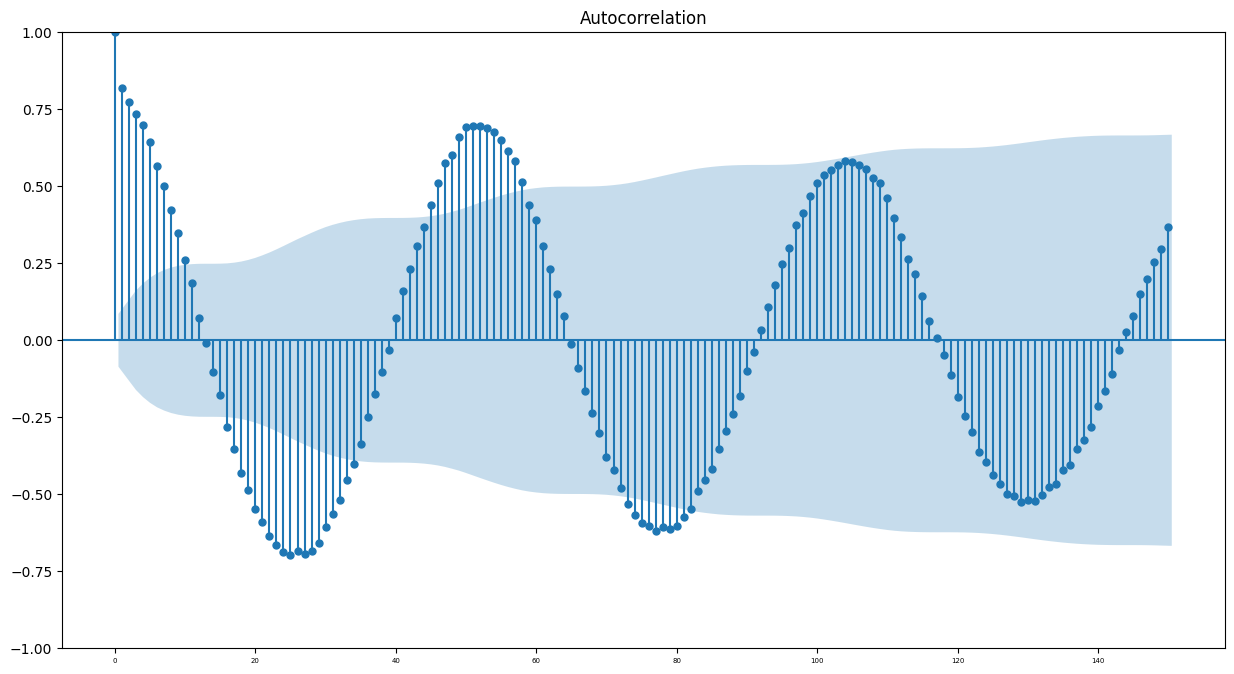

In [ ]:
plot_acf(weekly_temps['Temperature'], lags=150)
plt.show()
acf_vals = acf(weekly_temps['Temperature'], nlags=150)

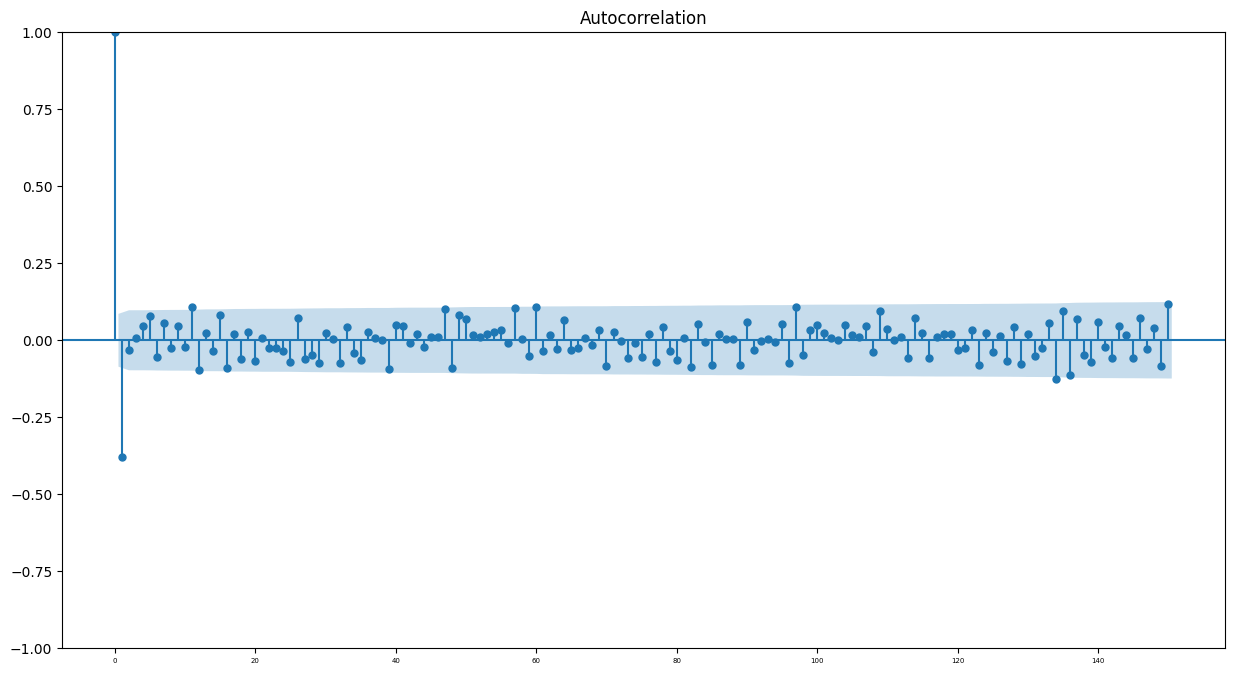

In [ ]:
plot_acf(weekly_temps['Dif_temp'], lags=150)
plt.show()
acf_vals = acf(weekly_temps['Dif_temp'], nlags=150)

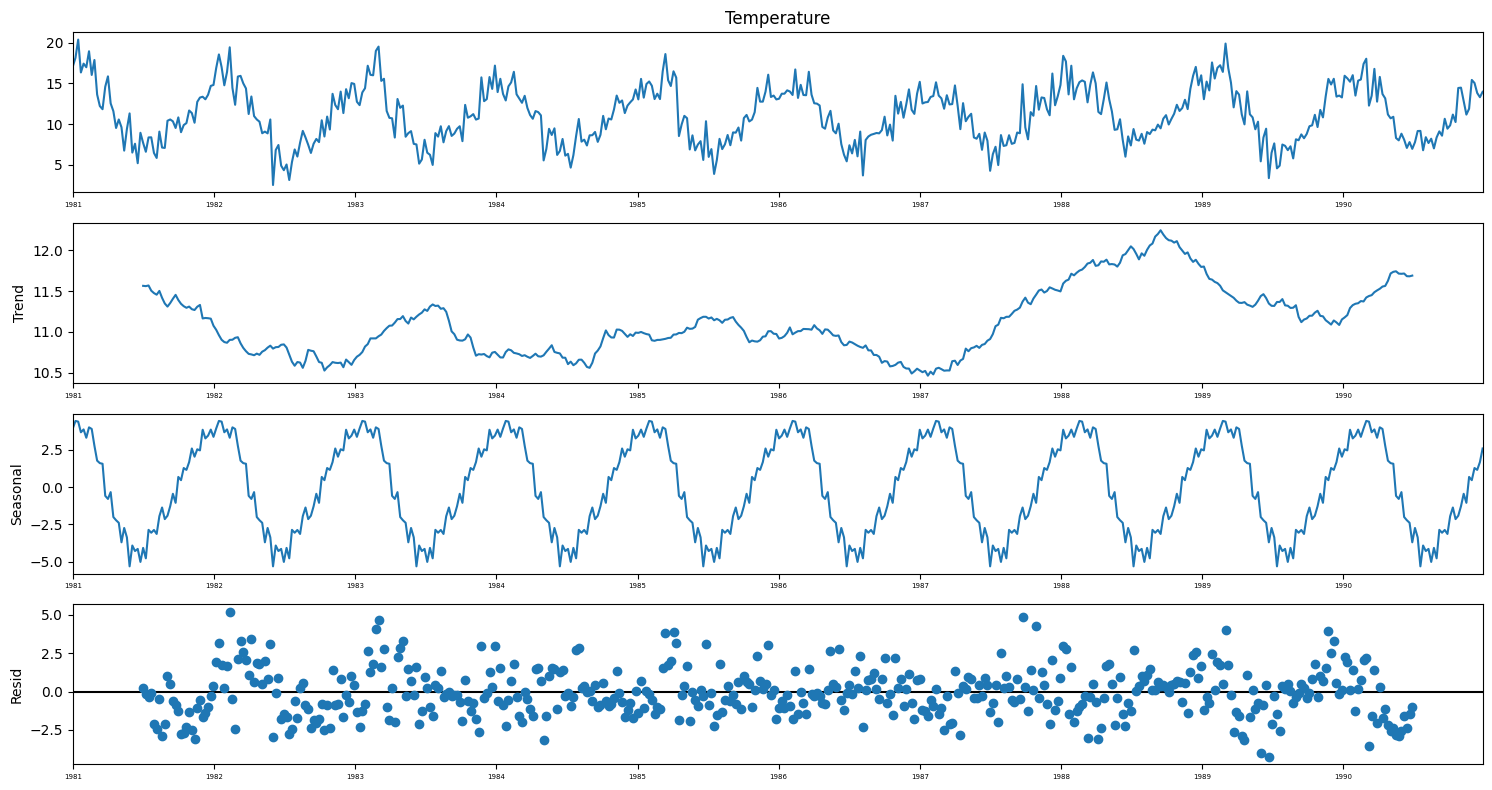

In [ ]:
rcParams['figure.figsize'] = 15, 8
rcParams['axes.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['xtick.labelsize'] = 5
decomposition = sm.tsa.seasonal_decompose(weekly_temps['Temperature'], model='additive',period=53)
decomp = decomposition.plot()

In [ ]:
adfuller(weekly_temps["Temperature"])

(-9.380112539193524,
 6.994154475206557e-16,
 19,
 502,
 {'1%': -3.4434437319767452,
  '5%': -2.8673146875484368,
  '10%': -2.569845688481135},
 1928.5801105556388)

Al ser pvalor menor a 0.05 rechazo H0 y es estacionaria segun dicky fuller

In [ ]:
kpss(weekly_temps["Temperature"])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.026164902307116752,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

quiero que mi pvalor sea mayor a 0.05 y es 0.1, por lo tanto no rechazo H0

# Modelos ARIMA

In [ ]:
model = ARIMA(weekly_temps['Temperature'], order=(0,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                  522
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1235.220
Date:                Sat, 22 Apr 2023   AIC                           2476.440
Time:                        15:51:08   BIC                           2489.213
Sample:                    01-01-1981   HQIC                          2481.443
                         - 12-27-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1891      0.180     62.064      0.000      10.836      11.542
ma.L1          0.6003      0.037     16.059      0.000       0.527       0.674
sigma2         6.6453      0.416     15.974      0.0

In [ ]:
model = ARIMA(weekly_temps['Dif_temp'], order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Dif_temp   No. Observations:                  522
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1054.818
Date:                Sat, 22 Apr 2023   AIC                           2117.635
Time:                        15:51:09   BIC                           2134.666
Sample:                    01-01-1981   HQIC                          2124.306
                         - 12-27-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0067      0.045     -0.151      0.880      -0.094       0.081
ar.L1         -0.0489      0.101     -0.482      0.630      -0.248       0.150
ma.L1         -0.4225      0.092     -4.597      0.0

# Modelos SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                        Temperature   No. Observations:                  522
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -948.452
Date:                            Sat, 22 Apr 2023   AIC                           1902.905
Time:                                    15:51:21   BIC                           1915.363
Sample:                                01-01-1981   HQIC                          1907.806
                                     - 12-27-1990                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2187      0.042      5.146      0.000       0.135       0.302
ma.S.L52      -0.7848      0.056   

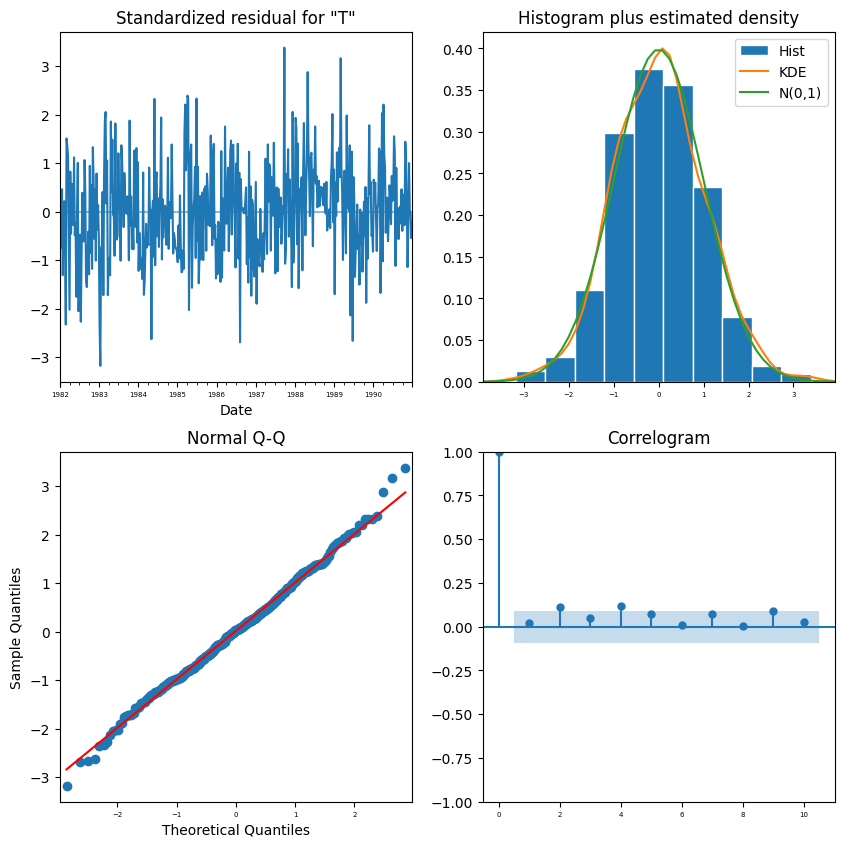

In [ ]:
model = SARIMAX(weekly_temps['Temperature'], order=(0,0,1), seasonal_order=(0,1,1,52))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10,10))
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                          Temperature   No. Observations:                  522
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 52)   Log Likelihood                -946.096
Date:                              Sat, 22 Apr 2023   AIC                           1900.192
Time:                                      15:51:42   BIC                           1916.803
Sample:                                  01-01-1981   HQIC                          1906.727
                                       - 12-27-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2367      0.042      5.629      0.000       0.154       0.319
ma.L2          0.09

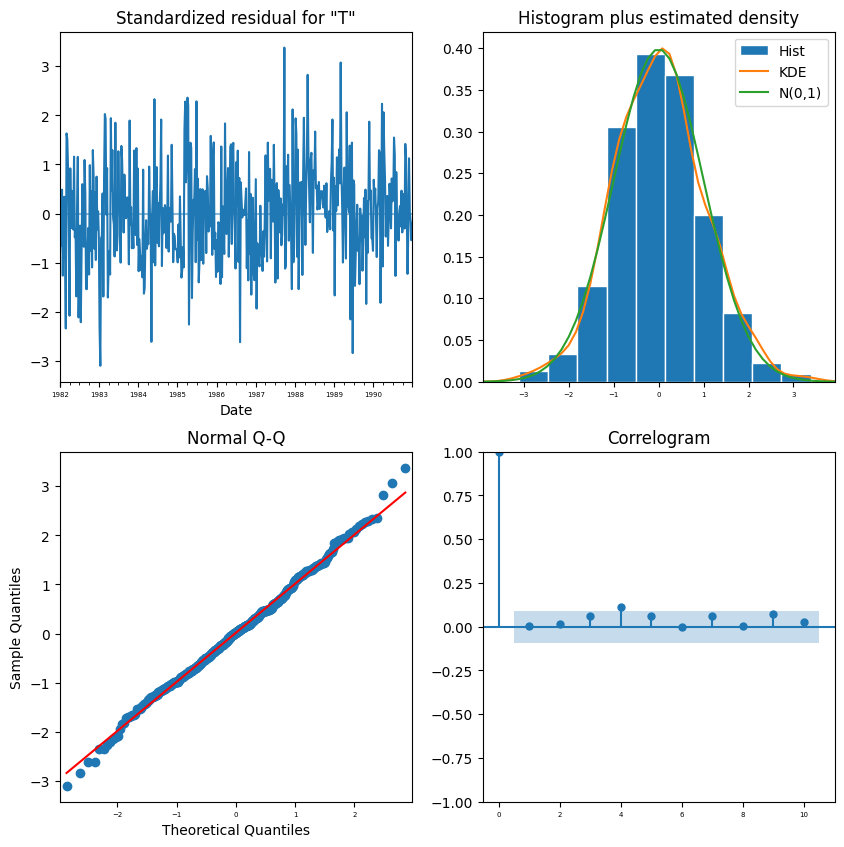

In [ ]:
model = SARIMAX(weekly_temps['Temperature'], order=(0,0,2), seasonal_order=(0,1,1,52))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10,10))
plt.show()

El modelo se puede mejorar

                                      SARIMAX Results                                      
Dep. Variable:                         Temperature   No. Observations:                  522
Model:             SARIMAX(0, 0, 3)x(0, 1, [], 52)   Log Likelihood               -1041.008
Date:                             Sat, 22 Apr 2023   AIC                           2090.016
Time:                                     15:51:47   BIC                           2106.627
Sample:                                 01-01-1981   HQIC                          2096.551
                                      - 12-27-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2006      0.047      4.281      0.000       0.109       0.292
ma.L2          0.0504      

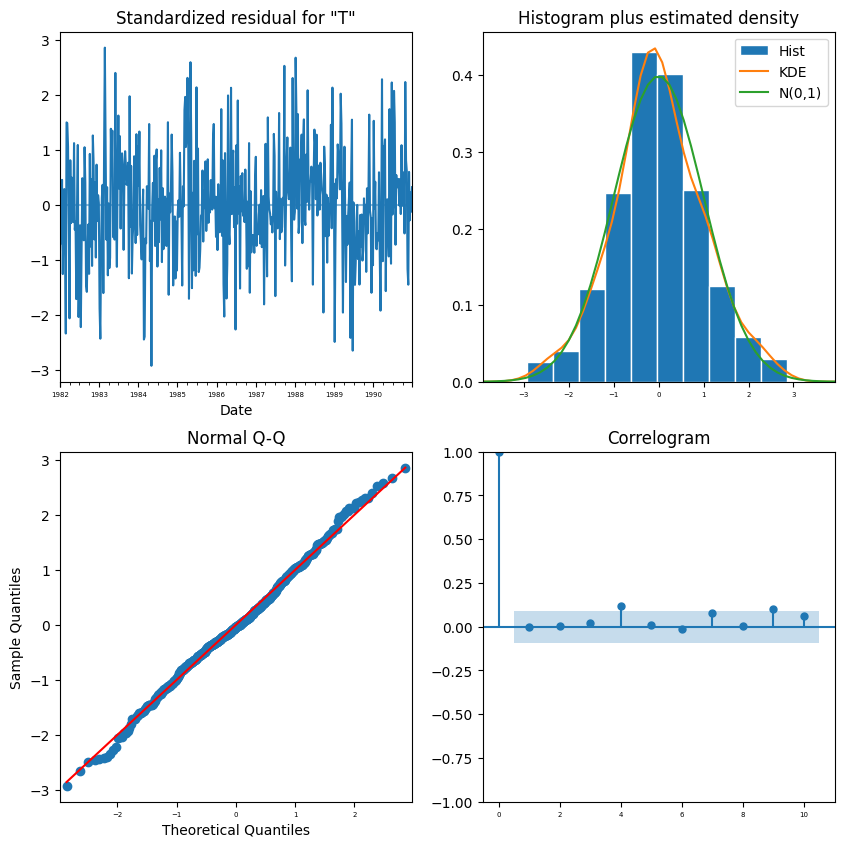

In [ ]:
model = SARIMAX(weekly_temps['Temperature'], order=(0,0,3), seasonal_order=(0,1,0,52))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10,10))
plt.show()

Un gráfico de residuos estandarizados frente a los valores ajustados del modelo. Este gráfico ayuda a detectar problemas de heterocedasticidad (varianza no constante) y no linealidad. Podemos ver que estan bastante bien.

Un histograma de los residuos estandarizados. Este gráfico ayuda a verificar si los residuos se distribuyen normalmente, lo cual en este caso se cumple.

Un gráfico Q-Q (quantile-quantile) de los residuos estandarizados. Este gráfico ayuda a verificar si los residuos se distribuyen normalmente.

Un gráfico de autocorrelación de los residuos. Este gráfico ayuda a detectar problemas de autocorrelación (correlación entre los residuos).

# BOXCOX

In [ ]:
weekly_temps['Dif_temp_bc'], lam = boxcox(dif_2-min(dif_2)+1)

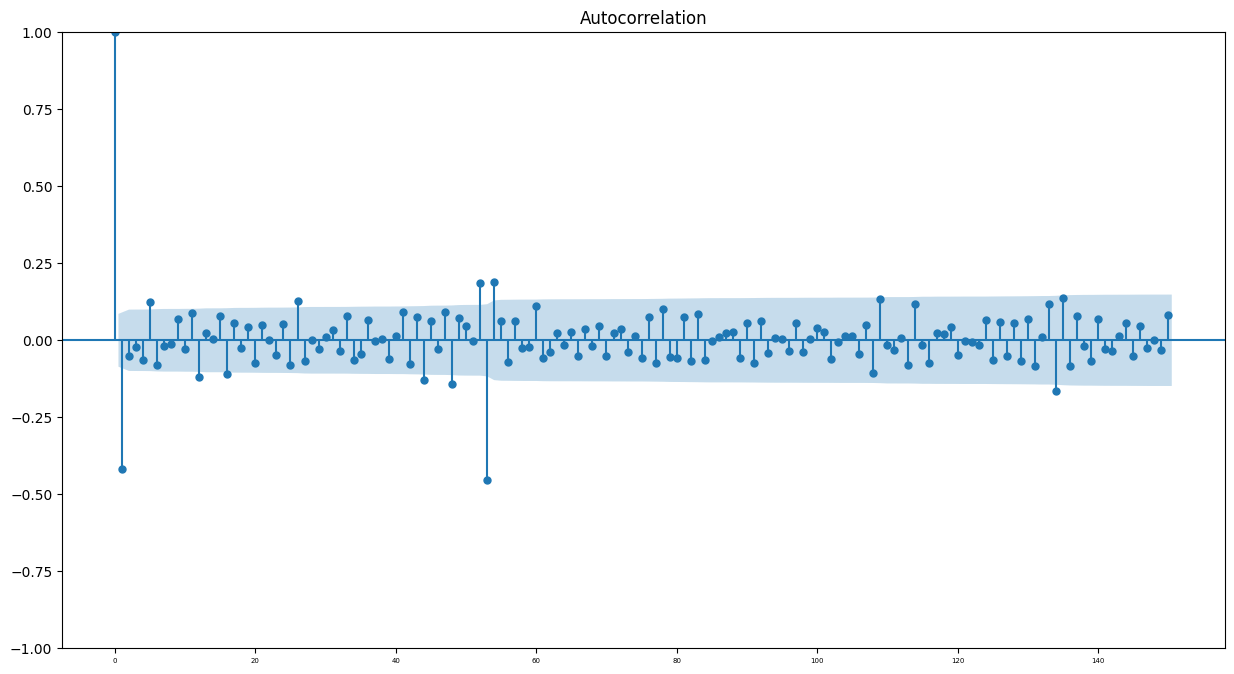

In [ ]:
plot_acf(weekly_temps['Dif_temp_bc'], lags=150)
plt.show()
acf_vals = acf(weekly_temps['Dif_temp_bc'], nlags=150)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


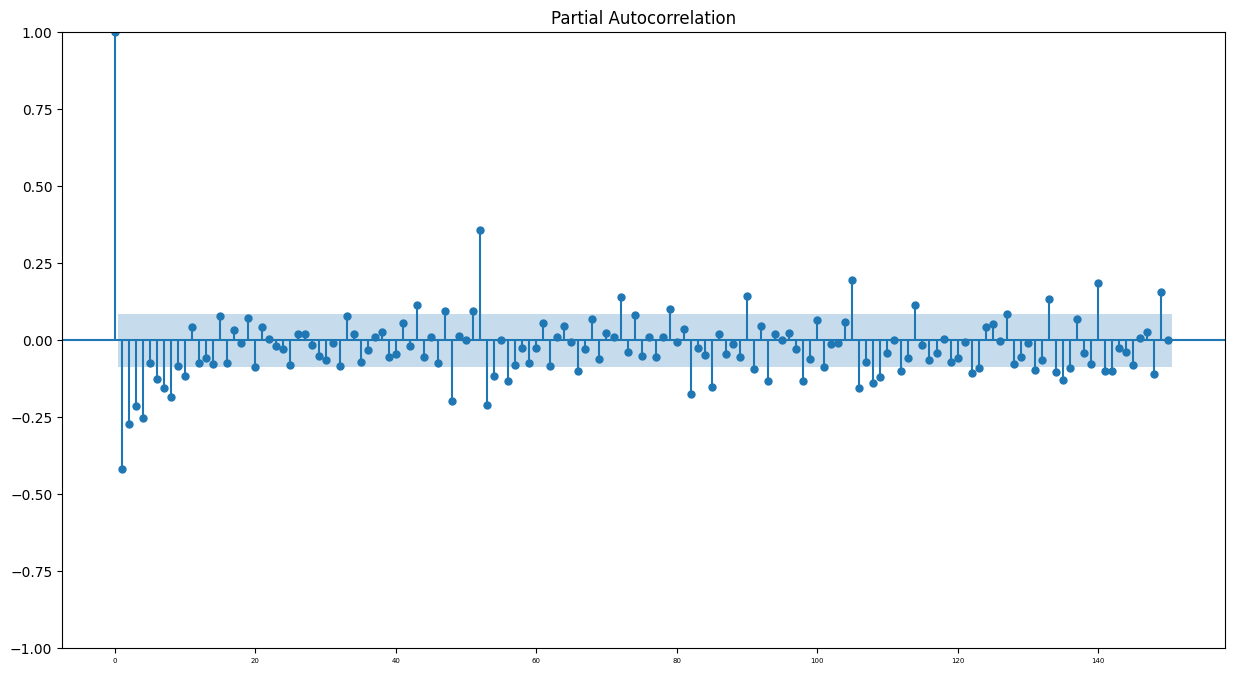

In [ ]:
plot_pacf(weekly_temps['Dif_temp_bc'], lags=150)
plt.show()
pacf_vals = pacf(weekly_temps['Dif_temp_bc'], nlags=150)

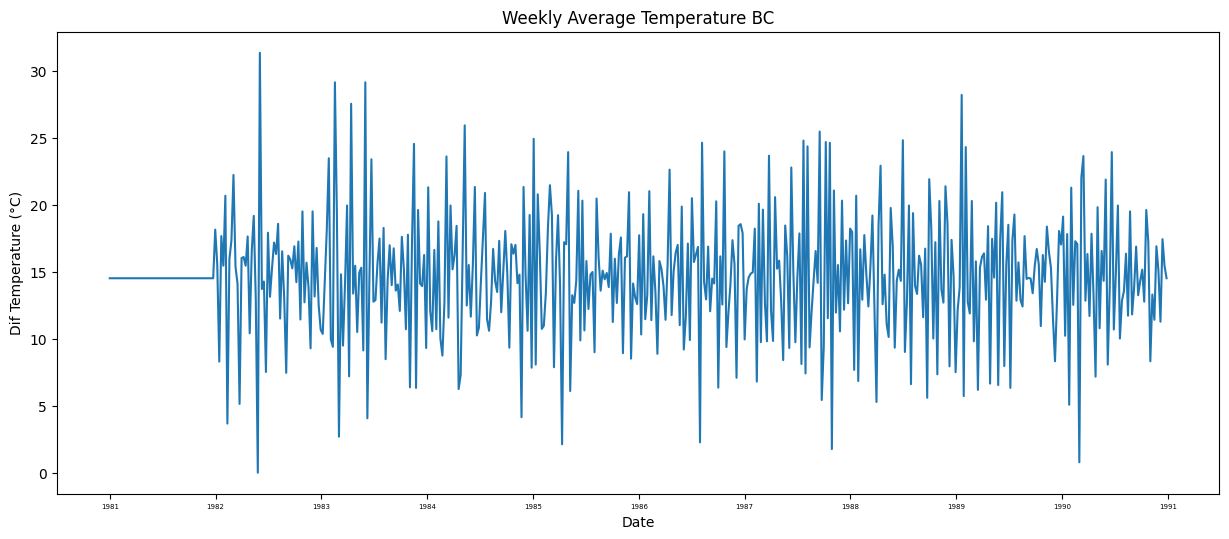

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.plot(weekly_temps['Dif_temp_bc'])
plt.xlabel('Date')
plt.ylabel('Dif Temperature (°C)')
plt.title('Weekly Average Temperature BC')
plt.show()

In [ ]:
model = SARIMAX(weekly_temps['Dif_temp_bc'], order=(0,0,3), seasonal_order=(0,0,1,53))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Dif_temp_bc   No. Observations:                  522
Model:             SARIMAX(0, 0, 3)x(0, 0, [1], 53)   Log Likelihood               -1857.805
Date:                              Sat, 22 Apr 2023   AIC                           3725.610
Time:                                      15:48:15   BIC                           3746.898
Sample:                                  01-01-1981   HQIC                          3733.948
                                       - 12-27-1990                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5806      0.041     14.160      0.000       0.500       0.661
ma.L2          0.57

Determino que el mejor modelo es un SARIMAX con order (0,0,2) y seasonal_order (0,1,1,52) para la variable Temperatura

# Walk Forward Validation

In [ ]:
# evaluate an SARIMAX model using a walk-forward validation
X = weekly_temps.Temperature.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
print(len(test))
# walk-forward validation


178


In [ ]:
for t in range(len(test)):
	model = SARIMAX(history, order=(0,0,3), seasonal_order=(0,1,0,52))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE: 2.253


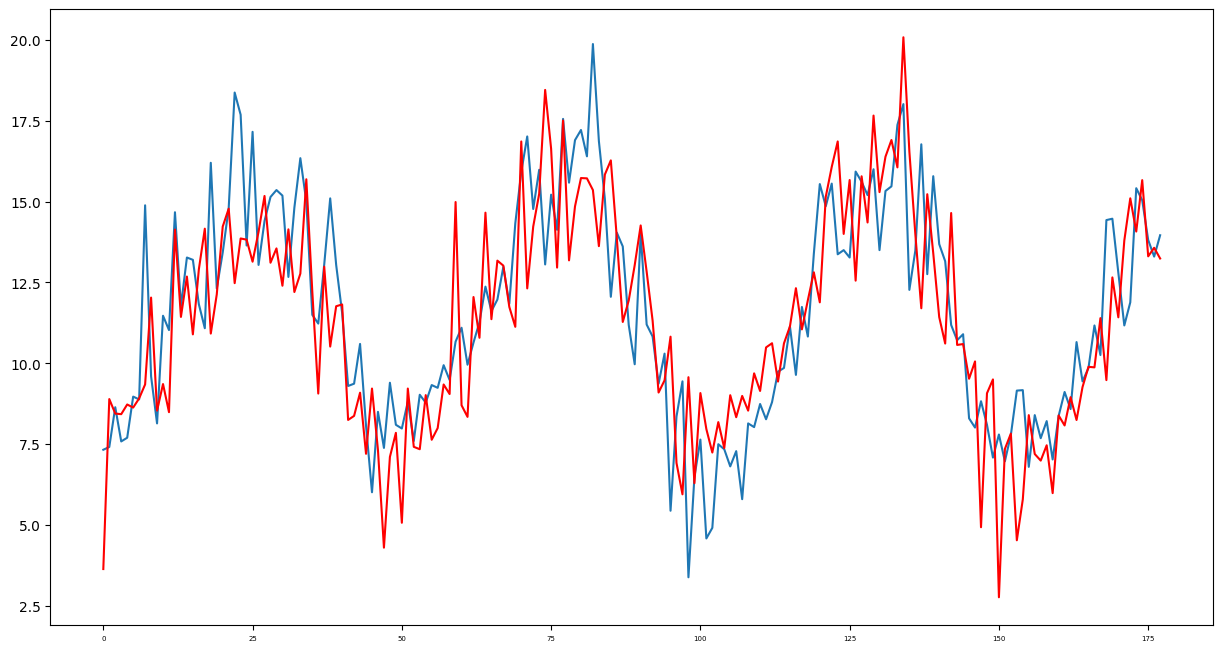

In [ ]:
# evaluate forecast
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

# LSTM

In [ ]:
X_train= []
y_train= []
X_test= []
y_test= []
ciclo = 7
for i in range(size-ciclo):
  X_train.append(train[i:i+ciclo])
  y_train.append([train[i+ciclo]])
for i in range(len(test)-ciclo):
  X_test.append(test[i:i+ciclo])
  y_test.append([test[i+ciclo]])
X_train= np.asarray(X_train)
y_train= np.asarray(y_train)
X_test= np.asarray(X_test)
y_test= np.asarray(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import keras

#Crear el modelo secuencial
model = Sequential()
ciclo=7
model.add(LSTM(64,activation='relu', input_shape = (ciclo , 1), return_sequences = True )) 
model.add(Dropout(0.15))
model.add(LSTM(64,activation='relu', return_sequences = True))
model.add(LSTM(8,activation='relu')) # La última capa LSTM no lleva return_sequences
model.add(Dense(1))

# Crear el modelo utilizando el optimizador recomendado por la documentación de keras
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Compilar el modelo con la función de pérdida requerida
model.compile(loss='mean_squared_error', optimizer=optimizer) #elijo usar el error cuadrático medio como función de pérdida

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=16)

# Evaluar el modelo en los datos de prueba
score = model.evaluate(X_test, y_test, batch_size=16)
print(f'Score net: {score}')

# Realizar predicciones en los datos de prueba
y_pred = model.predict(X_test)

Epoch 1/100
22/22 [==============================] - 6s 78ms/step - loss: 131.9137
Epoch 2/100
22/22 [==============================] - 1s 41ms/step - loss: 15.1161
Epoch 3/100
22/22 [==============================] - 1s 28ms/step - loss: 8.4242
Epoch 4/100
22/22 [==============================] - 0s 21ms/step - loss: 6.9538
Epoch 5/100
22/22 [==============================] - 1s 35ms/step - loss: 6.9784
Epoch 6/100
22/22 [==============================] - 0s 18ms/step - loss: 7.3309
Epoch 7/100
22/22 [==============================] - 0s 16ms/step - loss: 6.4360
Epoch 8/100
22/22 [==============================] - 0s 15ms/step - loss: 6.8729
Epoch 9/100
22/22 [==============================] - 0s 15ms/step - loss: 6.3626
Epoch 10/100
22/22 [==============================] - 0s 17ms/step - loss: 6.4704
Epoch 11/100
22/22 [==============================] - 0s 16ms/step - loss: 6.6574
Epoch 12/100
22/22 [==============================] - 0s 16ms/step - loss: 5.6192
Epoch 13/100
22/22 [==

Test RMSE: 1.810


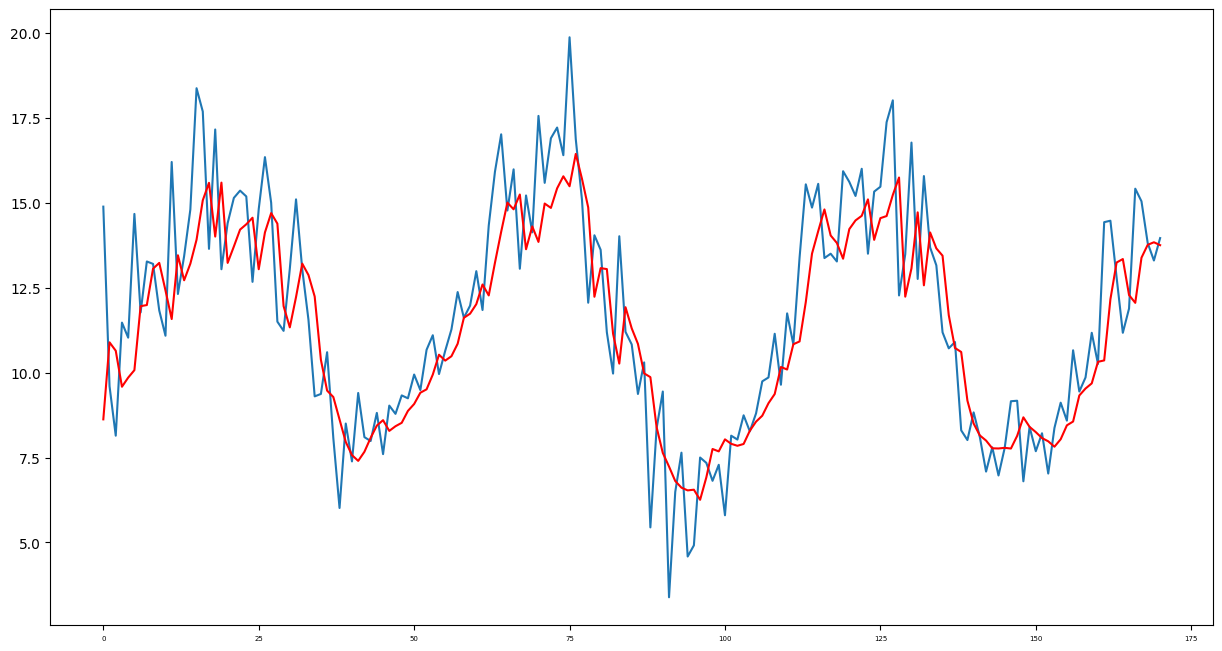

In [ ]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(y_test)
plt.plot(y_pred, color='red')
plt.show()

In [ ]:
predictions = list()
x_val = X_test[0]
for i in range(len(X_test)):
  #print(x_val)
  input=np.reshape(x_val, (1,len(x_val)))
  y_hat = model.predict(input)
  #print(y_hat)
  predictions.append(y_hat[0][0])
  x_val = np.concatenate((x_val[1:], y_hat[0]))
  #print(x_val)
  #break



1/1 [==============================] - 0s 35ms/step


Test RMSE: 4.517


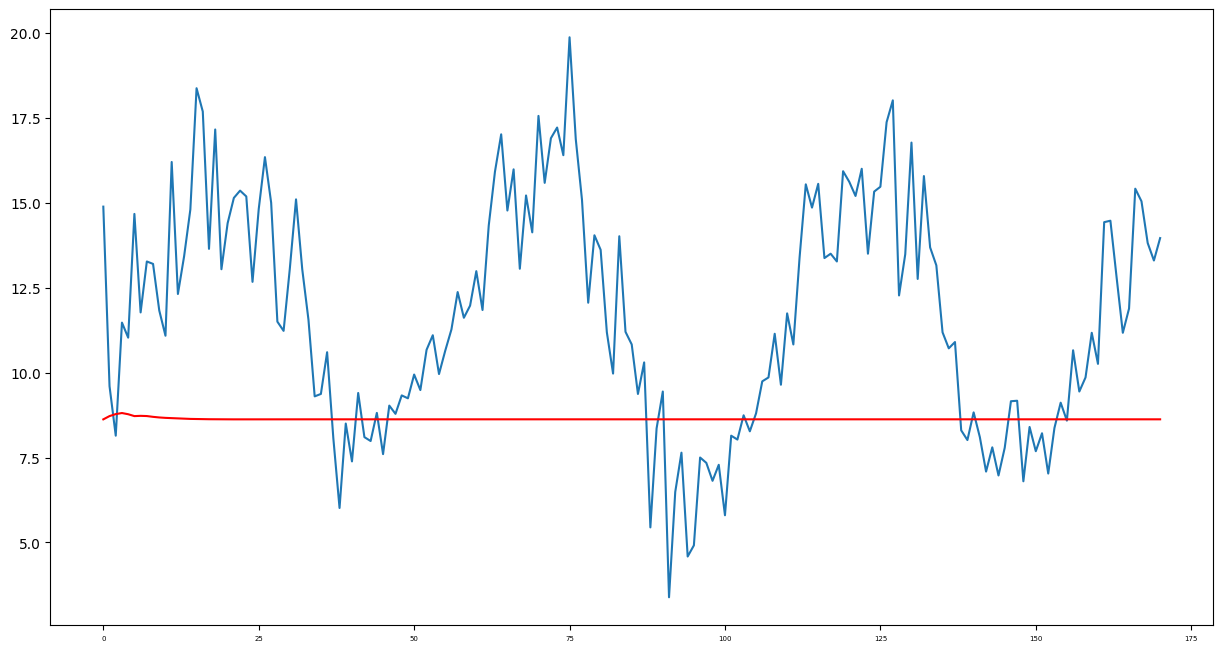

In [ ]:
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()

# Análisis Espectral

In [ ]:
G,Pyy_dnn = signal.periodogram(weekly_temps["Temperature"].values)

Text(0.5, 0, 'Frecuencia')

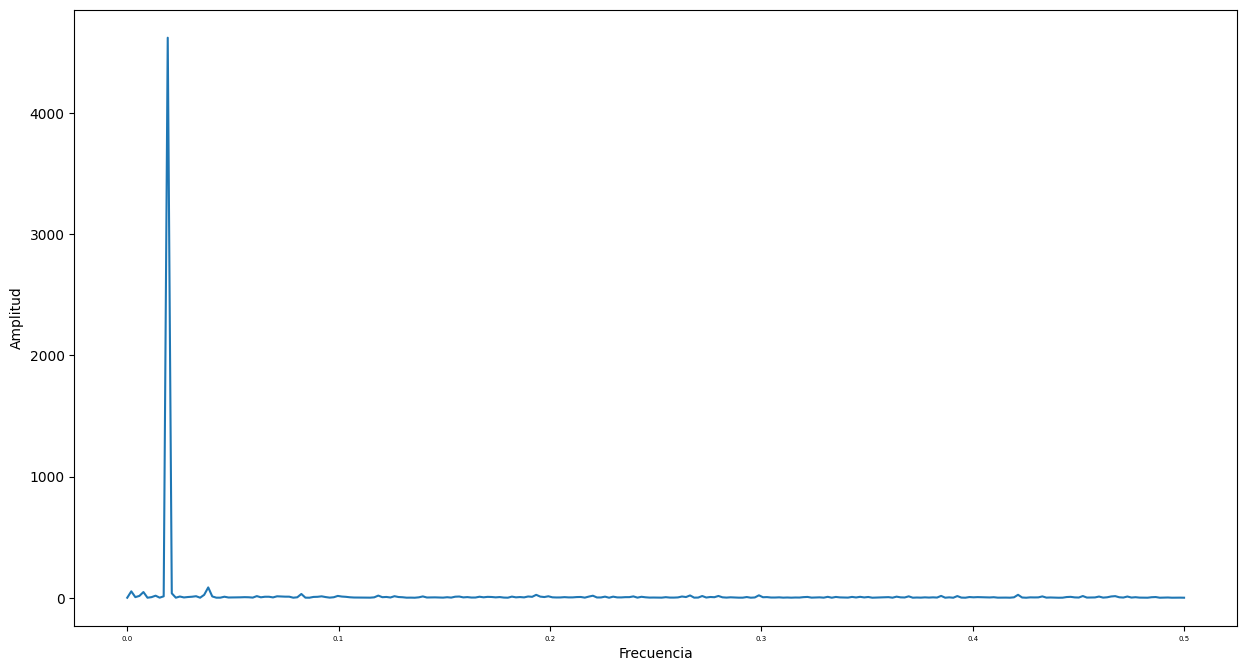

In [ ]:
plt.plot(G,Pyy_dnn)
plt.ylabel('Amplitud')
plt.xlabel('Frecuencia')

Tengo una frecuencia principal en 0.019 que se corresponde con mi ciclo de 52 y una frecuencia menor en 0.039 que sería la frecuencia que podemos ver como ruido en la representacion de la serie.